In [2]:
!pip install asrtoolkit
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install nltk

import asrtoolkit
from fuzzywuzzy import fuzz
import io
import os
from datetime import datetime
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
from nltk.metrics import distance
import string
from difflib import Differ

# Load and prep statistics

In [3]:
filenames = list(Path('predictions').glob('*.csv'))

results = pd.DataFrame()

models = list()

for idx, filename in enumerate(filenames):
    new_results = pd.read_csv(filename)
    model_label = Path(filename).stem.split('-')[0]
    ground_truth_label = f'{model_label}-ground_truth'
    new_results = new_results.rename(columns={'label': ground_truth_label, 
                            'prediction': model_label})
    del new_results['Unnamed: 0']
    models.append((ground_truth_label, model_label))
    new_results[ground_truth_label] = new_results.apply(lambda r: str(r[ground_truth_label]), axis=1)
    new_results[model_label] = new_results.apply(lambda r: str(r[model_label]), axis=1)
    results = pd.concat([results, new_results], axis = 1)

results

,fine_tuned-ground_truth,fine_tuned,retrained-ground_truth,retrained
0,.),"""",.),""""
1,Maxon,Maan,Maxon,saan
2,delitescens,dillilconan,delitescens,didlicone
3,radicans,Pilicana,radicans,Bilicana'
4,Damp,trtt,Damp,tate
...,...,...,...,...
400,ropinqua,pospirnou,ropinqua,pospirspove
401,macrosora,aarsu,macrosora,aarssou
402,Chr,po.,Chr,ph.
403,Polypodium,Beleuiaem,Polypodium,Bolebesa


In [4]:
models

[('fine_tuned-ground_truth', 'fine_tuned'),
 ('retrained-ground_truth', 'retrained')]

In [5]:
NUM_STATS = 6
NUM_SUB_STATS = 5
a = ['matchratio'] * NUM_SUB_STATS + ['CER'] * NUM_SUB_STATS + ['matchratio_insensitive'] * NUM_SUB_STATS + ['CER_insensitive'] * NUM_SUB_STATS + ['matchratio_nopunc'] * NUM_SUB_STATS + ['CER_nopunc'] * NUM_SUB_STATS
b = ['mean', 'min', 'max', 'stdev', 'median'] * NUM_STATS
headers = pd.MultiIndex.from_arrays([a,b], names=('stat', 'substats'))
summary_results = pd.DataFrame(columns=headers)

def apply_stat(model_label: str, query_label: str, summary_stat_label: str, stat_function):
    results[query_label] = subset.apply(stat_function, axis=1)
    summary_results.loc[model_label, (summary_stat_label, 'mean')] = results[query_label].mean()
    summary_results.loc[model_label, (summary_stat_label, 'stdev')] = results[query_label].std()
    summary_results.loc[model_label, (summary_stat_label, 'min')] = results[query_label].min()
    summary_results.loc[model_label, (summary_stat_label, 'median')] = results[query_label].median()
    summary_results.loc[model_label, (summary_stat_label, 'max')] = results[query_label].max()
    subset[query_label] = results[query_label]
    
for ground_truth_label, model_label in models:
    subset = results[[ground_truth_label, model_label]].dropna()
    
    apply_stat(model_label, f'{model_label} CER', 'CER', lambda r: asrtoolkit.cer(str(r[ground_truth_label]), str(r[model_label])))
    apply_stat(model_label, f'{model_label} match ratio', 'matchratio', lambda r: fuzz.ratio(str(r[ground_truth_label]), str(r[model_label])))
    results[f'{model_label}-edit_distance'] = subset.apply(lambda r: distance.edit_distance(str(r[ground_truth_label]), str(r[model_label])), axis=1)
    
    subset[f'{ground_truth_label}-lower'] = subset[ground_truth_label].map(str.lower)
    subset[f'{model_label}-lower'] = subset[model_label].map(str.lower)
    apply_stat(model_label, f'{model_label} CER insensitive', 'CER_insensitive', lambda r: asrtoolkit.cer(str(r[f'{ground_truth_label}-lower']), str(r[f'{model_label}-lower'])))
    apply_stat(model_label, f'{model_label} match ratio insensitive', 'matchratio_insensitive', lambda r: fuzz.ratio(str(r[f'{ground_truth_label}-lower']), str(r[f'{model_label}-lower'])))
    
    subset[f'{ground_truth_label}-nopunc'] = subset[ground_truth_label].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
    subset = subset.loc[subset[f'{ground_truth_label}-nopunc'].str.len() > 0]
    subset[f'{model_label}-nopunc'] = subset[model_label].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
    subset = subset.loc[subset[f'{model_label}-nopunc'].str.len() > 0]
    apply_stat(model_label, f'{model_label} CER no punc', 'CER_nopunc', lambda r: asrtoolkit.cer(str(r[f'{ground_truth_label}-nopunc']), str(r[f'{model_label}-nopunc'])))
    apply_stat(model_label, f'{model_label} match ratio no punc', 'matchratio_nopunc',  lambda r: fuzz.ratio(str(r[f'{ground_truth_label}-lower']), str(r[f'{model_label}-lower'])))
    
    exact = results.apply(lambda r: 1 if int(r[f'{model_label}-edit_distance']) == 0 else 0, axis=1).sum()
    oboe = results.apply(lambda r: 1 if int(r[f'{model_label}-edit_distance']) == 1 else 0, axis=1).sum()
    summary_results.loc[model_label, 'exact_matches'] = pd.to_numeric(exact, downcast='integer')
    summary_results.loc[model_label, 'oboe_matches'] = pd.to_numeric(oboe, downcast='integer')
    
    err_range = stats.norm.interval(alpha=0.95, 
                                  loc=np.mean(results[f'{model_label} CER'].dropna()), 
                                  scale=stats.sem(results[f'{model_label} CER'].dropna()))
    summary_results.loc[model_label, 'cer_95_error_min'] = err_range[0]
    summary_results.loc[model_label, 'cer_95_error_max'] = err_range[1]

In [6]:
print(summary_results[[('CER', 'mean'), ('CER_insensitive', 'mean'), ('CER_nopunc', 'mean'), 
                       ('matchratio', 'mean'), ('matchratio_insensitive', 'mean'), ('matchratio_nopunc', 'mean')]])
print(summary_results[['exact_matches', 'oboe_matches', 'cer_95_error_min', 'cer_95_error_max']])

stat              CER CER_insensitive CER_nopunc matchratio  \
substats         mean            mean       mean       mean   
fine_tuned  82.642721       82.642721  81.595089  32.355556   
retrained   85.369435       85.418818  85.361541  29.454321   

stat       matchratio_insensitive matchratio_nopunc  
substats                     mean              mean  
fine_tuned              34.254321         35.231383  
retrained               31.377778         32.470588  
stat       exact_matches oboe_matches cer_95_error_min cer_95_error_max
substats                                                               
fine_tuned           3.0         24.0        76.661839        88.623603
retrained            1.0         23.0        82.230860        88.508010


# Generate and display graphs

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


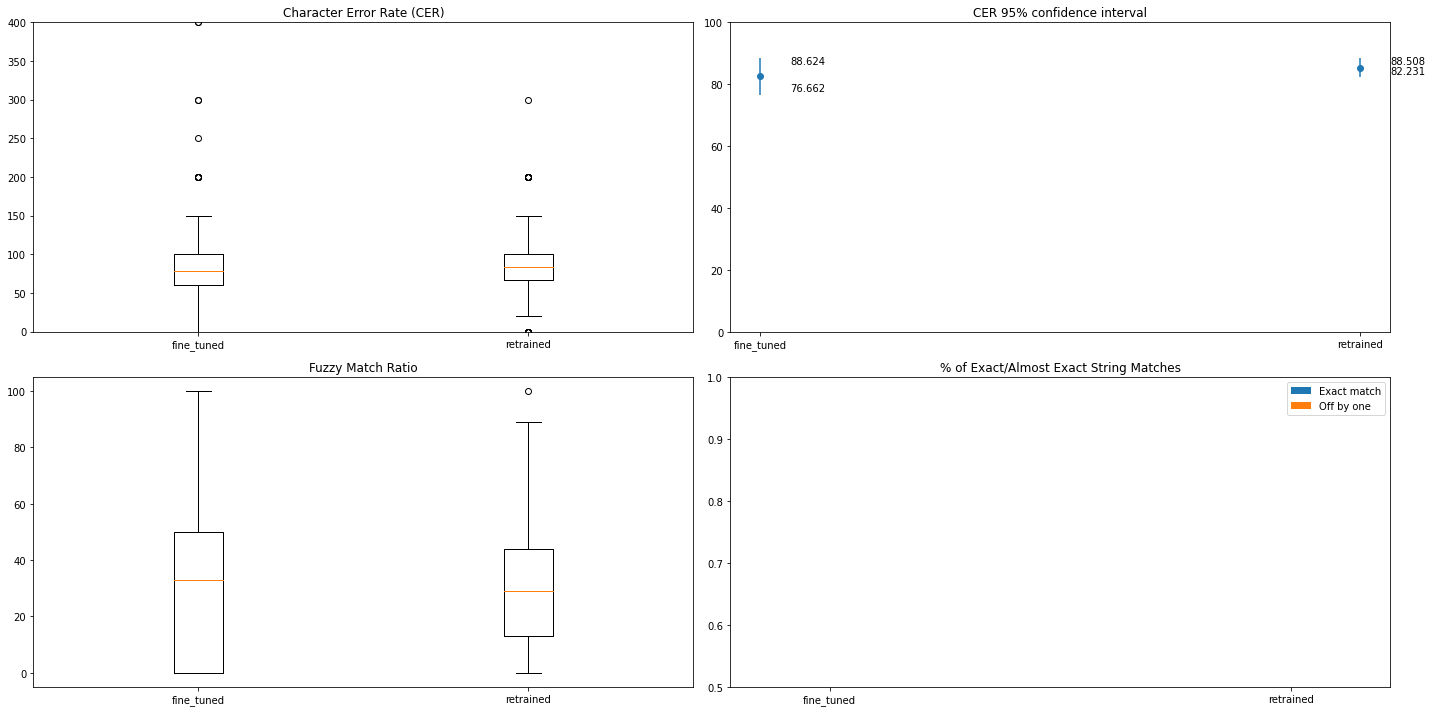

In [8]:
def plot_cer(graph):
    graph.set_title('Character Error Rate (CER)')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim([-1, 400])
    subset = results[[f'{label[1]} CER' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_cer_confidence_interval(graph):
    min = summary_results['cer_95_error_min']
    min = min.apply(lambda v: v if v >= 0 else 0)
    max = summary_results['cer_95_error_max']
    max = max.apply(lambda v: v if v <= 100 else 100)
    error_min = [summary_results.loc[label[1], ('CER', 'mean')] - min[label[1]] for label in models]
    error_max = [max[label[1]] - summary_results.loc[label[1], ('CER', 'mean')] for label in models]
    graph.set_title('CER 95% confidence interval')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim(top=100)
    graph.errorbar([label[1] for label in models], summary_results[('CER', 'mean')], yerr=[error_min, error_max], fmt='o')
    for i in range(len(models)):
        graph.text(i + 0.05, max[i] - 2, f'{max[i]:.3f}')
        graph.text(i + 0.05, min[i] + 1, f'{min[i]:.3f}')


def plot_fuzzy_match(graph):
    graph.set_title('Fuzzy Match Ratio')
    graph.set_xticklabels([label[1] for label in models])
    subset = results[[f'{label[1]} match ratio' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_close_matches(graph):  # todo
    graph.set_title('% of Exact/Almost Exact String Matches')
    exact_matches = [match/results.shape[0] for match in summary_results['exact_matches']]
    obo_matches = [match/results.shape[0] for match in summary_results['oboe_matches']]
    ex = graph.bar([label[1] for label in models], exact_matches, 
                   width=0.3, label='Exact match')
    obo = graph.bar([label[1] for label in models], obo_matches, 
                    width=0.3, bottom=exact_matches, label='Off by one')
    graph.set_ybound(0.5, 1)
    graph.legend()


fig, ((graph1, graph2), (graph3, graph4)) = plt.subplots(2, 2, figsize=(20, 10))
# fig, graph1 = plt.subplots(1, 1, figsize=(10, 7))  # For saving individual charts

plot_cer(graph1)
plot_cer_confidence_interval(graph2)
plot_fuzzy_match(graph3)
plot_close_matches(graph4)
fig.tight_layout()

# OBO String Comparisons

In [ ]:
from Bio import pairwise2
from Bio.Seq import Seq
seq1 = Seq('foot')
seq2 = Seq('moot')
a = pairwise2.align.globalxx(seq1, seq2)
print(pairwise2.format_alignment(*a[0]))
a[0].end

In [100]:
d = Differ()
substitution_errors = list()
deletion_errors = [dict()]
CHAR_LIST = '\' !"#&()[]*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
deletion_errors[0] = {c:0 for c in list(CHAR_LIST)}
insertion_errors = deletion_errors * 4
deletion_errors = deletion_errors * 4
    
for ground_truth_label, model_label in models:
    oboe = results[results[f'{model_label}-edit_distance'] == 1][[ground_truth_label, model_label]]
    subs = dict()
    dels = deletion_errors[len(models) - 1]
    ins = deletion_errors[len(models) - 1]
    # print(oboe)
    for idx, row in oboe.iterrows():
        differ_result = list(d.compare(row[ground_truth_label], row[model_label]))
        removed = [c[2] for c in differ_result if c[0] == '-']
        added = [c[2] for c in differ_result if c[0] == '+']
        assert len(removed) < 2 and len(added) < 2, f'Lens are wrong, -: {removed}, +: {added}'
        if len(row[ground_truth_label]) == len(row[model_label]):
            sub_chars = (removed[0], added[0])
            # print(f'sub: {sub_chars}')
            if sub_chars in subs.keys():
                subs[sub_chars] += 1
            else:
                subs[sub_chars] = 1
        elif len(row[ground_truth_label]) > len(row[model_label]):
            del_char = removed[0]
            # print(f'del: {del_char}')
            dels[del_char] += 1
        else:
            ins_char = added[0]
            # print(f'ins: {ins_char}')
            ins[ins_char] += 1
    substitution_errors.append(subs)
    deletion_errors.append(dels)
    insertion_errors.append(ins)
substitution_errors = [dict(sorted(a.items(), key=lambda item: item[1], reverse=True)) for a in substitution_errors]
# deletion_errors = [dict(sorted(a.items(), key=lambda item: item[1], reverse=True)) for a in deletion_errors]
# insertion_errors = [dict(sorted(a.items(), key=lambda item: item[1], reverse=True)) for a in insertion_errors]

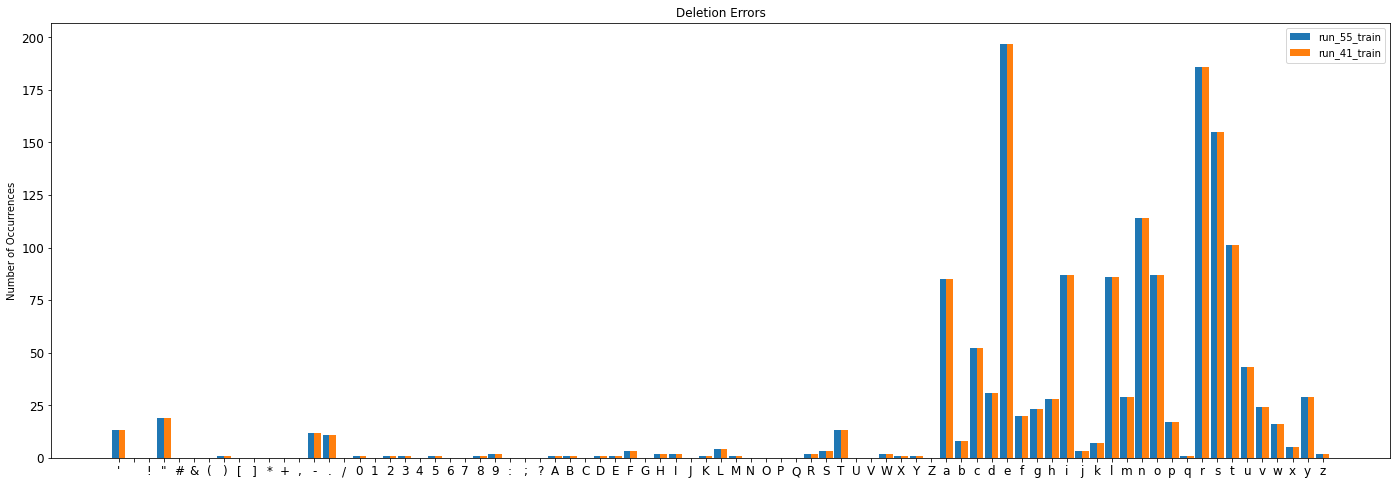

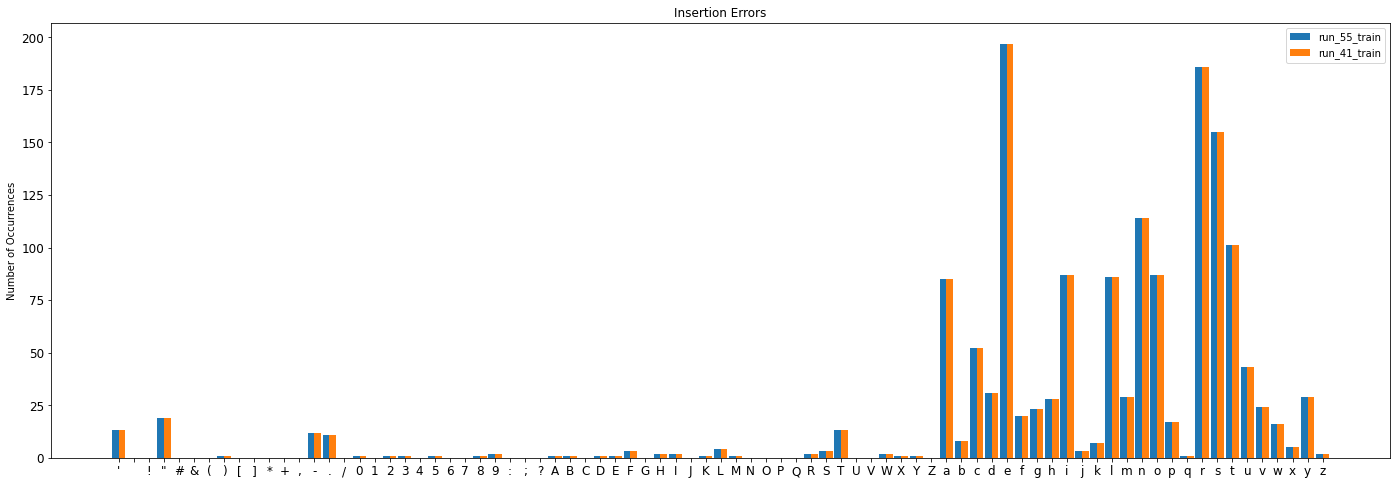

In [124]:
# print('Top Substitutions:')
# for key in list(substitution_errors[0])[:10]:
#     print(f'{key}: {substitution_errors[0][key]}')
# print('\nTop Deletions:')
# for key in list(deletion_errors[0])[:10]:
#     print(f'{key}: {deletion_errors[0][key]}')
# print('\nTop Insertions:')
# for key in list(insertion_errors[0])[:10]:
#     print(f'{key}: {insertion_errors[0][key]}')

plt.figure(figsize=(24,8))
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.bar(np.arange(len(deletion_errors[0].keys())) - 0.225, deletion_errors[0].values(), 0.45, label = models[0][1])
plt.bar(np.arange(len(deletion_errors[0].keys())) + 0.225, deletion_errors[1].values(), 0.45, label = models[1][1])
plt.xticks(np.arange(len(deletion_errors[0].keys())) , deletion_errors[0].keys())
plt.title("Deletion Errors")
plt.ylabel("Number of Occurrences")
plt.legend()
plt.show()

plt.figure(figsize=(24,8))
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.bar(np.arange(len(insertion_errors[0].keys())) - 0.225, insertion_errors[0].values(), 0.45, label = models[0][1])
plt.bar(np.arange(len(insertion_errors[0].keys())) + 0.225, insertion_errors[1].values(), 0.45, label = models[1][1])
plt.xticks(np.arange(len(insertion_errors[0].keys())) , insertion_errors[0].keys())
plt.title("Insertion Errors")
plt.ylabel("Number of Occurrences")
plt.legend()
plt.show()

In [173]:
list_of_changes = list()
for ground_truth_label, model_label in models:
    oboes = results[results[f'{model_label}-edit_distance']==1][[f'{model_label}-ground_truth', model_label]]
    diffs = oboes.apply(lambda r: list(d.compare(r[f'{model_label}-ground_truth'], r[model_label])), axis=1)
    diffs = diffs.apply(lambda r: [a for a in r if a[0] == '+' or a[0] == '-'])
    list_of_changes.append(diffs)
print(list_of_changes[0][0:10])
missing = list()
added = list()
for changes in list_of_changes:
    missing_this_model = list()
    added_this_model = list()
    for change_list in changes:
        for change in change_list:
            if change[0] == '+':
                added_this_model.append(change[2:])
            elif change[0] == '-':
                missing_this_model.append(change[2:])
    missing.append(missing_this_model)
    added.append(added_this_model)
print(missing[0][0:10])
print(added[0][0:10])
# char_sub_summary = pd.DataFrame(columns=['Missing])

0     [- A, + "]
3     [- F, + T]
6     [- o, + e]
17         [+ t]
22    [+ I, - l]
23         [+ c]
30    [- B, + S]
37    [- ,, + "]
40    [- S, + s]
47         [- s]
dtype: object
['A', 'F', 'o', 'l', 'B', ',', 'S', 's', ',', 'D']
['"', 'T', 'e', 't', 'I', 'c', 'S', '"', 's', '"']


# Save these results to the filesystem

In [131]:
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
timestamp = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
summary_results.to_csv(Path(results_folder, f'summary-{timestamp}.csv'))
fig.savefig(Path(results_folder, f'summary-{timestamp}.png'))